# EXPERIMENT: Compare CNN vs CNN+MLP vs CNN+KAN (MNIST)
This notebook trains:
- **Model A (CNN-only):** Small CNN backbone + linear head
- **Model B (CNN+MLP):** Same backbone + 2-layer MLP head
- **Model C (CNN+KAN):** Freeze the trained CNN backbone, extract features, fit a KAN head on features

All three are evaluated on MNIST test accuracy.

## 1) Install

In [ ]:
%pip install -q -U pip setuptools wheel
%pip install -q -U pykan cmake ninja pybind11 tqdm
# torchvision and torch come preinstalled on Colab; we avoid reinstalling to prevent CUDA mismatches.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


## 2) Imports & setup

In [ ]:
import time, math, random
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from kan import KAN

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)


device: cpu


## 3) Data (MNIST)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Optional: subsample to keep the demo fast
MAX_TRAIN = 30000  # set to None for full
if MAX_TRAIN is not None:
    idx = list(range(len(train_ds)))[:MAX_TRAIN]
    train_ds = Subset(train_ds, idx)

BATCH = 128
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
len(train_ds), len(test_ds)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.44MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 158kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.79MB/s]


(30000, 10000)

## 4) Models: CNN backbone + heads

In [ ]:
class CNNBackbone(nn.Module):
    def __init__(self, out_channels=16):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(16),
            nn.MaxPool2d(2),  # 28->14
            nn.Conv2d(16, out_channels, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(out_channels),
        )
        self.gap = nn.AdaptiveAvgPool2d((1,1))

    def forward(self, x):
        x = self.conv(x)
        x = self.gap(x)
        return x.view(x.size(0), -1)  # (B, C)

class CNNLinear(nn.Module):
    def __init__(self, feat_dim=16, num_classes=10):
        super().__init__()
        self.backbone = CNNBackbone(out_channels=feat_dim)
        self.head = nn.Linear(feat_dim, num_classes)

    def forward(self, x):
        feats = self.backbone(x)
        return self.head(feats)

class CNNMLP(nn.Module):
    def __init__(self, feat_dim=16, num_classes=10):
        super().__init__()
        self.backbone = CNNBackbone(out_channels=feat_dim)
        self.head = nn.Sequential(nn.Linear(feat_dim, 32), nn.ReLU(), nn.Linear(32, num_classes))

    def forward(self, x):
        feats = self.backbone(x)
        return self.head(feats)


## 5) Train/Eval utilities (for CNN variants)

In [ ]:
def train_cnn(model, loader, optimizer, epochs=2):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    for ep in range(epochs):
        model.train()
        running = 0.0
        for x,y in loader:
            x,y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            running += loss.item()*x.size(0)
        print(f"epoch {ep+1}/{epochs} | train_loss={running/len(loader.dataset):.4f}")

@torch.no_grad()
def eval_acc(model, loader):
    model.eval(); model.to(device)
    correct = total = 0
    for x,y in loader:
        x,y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return correct/total


## 6) Train **Model A: CNN-only (linear head)**

In [ ]:
model_a = CNNLinear(feat_dim=16, num_classes=10)
opt_a = torch.optim.Adam(model_a.parameters(), lr=1e-3)
t0 = time.time(); train_cnn(model_a, train_loader, opt_a, epochs=2); t1 = time.time()
acc_a = eval_acc(model_a, test_loader)
print(f"Model A test acc: {acc_a:.4f} | train time: {t1-t0:.1f}s")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 1/2 | train_loss=1.8906
epoch 2/2 | train_loss=1.3128
Model A test acc: 0.8050 | train time: 34.8s


## 7) Train **Model B: CNN+MLP head**

In [ ]:
model_b = CNNMLP(feat_dim=16, num_classes=10)
opt_b = torch.optim.Adam(model_b.parameters(), lr=1e-3)
t0 = time.time(); train_cnn(model_b, train_loader, opt_b, epochs=2); t1 = time.time()
acc_b = eval_acc(model_b, test_loader)
print(f"Model B test acc: {acc_b:.4f} | train time: {t1-t0:.1f}s")

epoch 1/2 | train_loss=1.8247
epoch 2/2 | train_loss=0.9116
Model B test acc: 0.8209 | train time: 33.0s


## 8) Freeze CNN backbone & extract features (for KAN)

In [ ]:
@torch.no_grad()
def extract_features(backbone, loader):
    backbone.eval(); backbone.to(device)
    feats_list, labels_list = [], []
    for x,y in loader:
        x = x.to(device, non_blocking=True)
        feats = backbone(x)
        feats_list.append(feats)
        labels_list.append(y)
    X = torch.cat(feats_list, dim=0)
    y = torch.cat(labels_list, dim=0)
    return X, y

# Use the backbone from Model A for a fair feature extractor
backbone = model_a.backbone
Xtr, ytr = extract_features(backbone, train_loader)
Xte, yte = extract_features(backbone, test_loader)
print('feature shapes:', Xtr.shape, Xte.shape)

# One-hot labels for KAN (KAN uses regression-style loss)
num_classes = 10
Ytr = torch.zeros(Xtr.size(0), num_classes, device=device)
Ytr.scatter_(1, ytr.unsqueeze(1).to(device), 1.0)
Yte = torch.zeros(Xte.size(0), num_classes, device=device)
Yte.scatter_(1, yte.unsqueeze(1).to(device), 1.0)

dataset_kan = {
    'train_input': Xtr,
    'train_label': Ytr,
    'test_input':  Xte,
    'test_label':  Yte,
}

feature shapes: torch.Size([30000, 16]) torch.Size([10000, 16])


## 9) Train **Model C: KAN head on frozen CNN features**

In [ ]:
feat_dim = Xtr.shape[1]
kan_model = KAN(width=[feat_dim, 32, 10], grid=5, k=3, seed=0, device=device)

# A short LBFGS run; increase steps for better accuracy
t0 = time.time()
kan_model.fit(dataset_kan, opt='LBFGS', steps=60, lamb=0.0, lamb_entropy=0.0)
t1 = time.time()

@torch.no_grad()
def kan_accuracy(model, X, y_true):
    logits = model(X)
    pred = logits.argmax(dim=1).cpu()
    return (pred == y_true.cpu()).float().mean().item()

acc_c = kan_accuracy(kan_model, Xte, yte)
print(f"Model C (CNN+KAN) test acc: {acc_c:.4f} | fit time: {t1-t0:.1f}s")

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.03e-01 | test_loss: 1.06e-01 | reg: 1.01e+02 | : 100%|█| 60/60 [43:57<00:00, 43.96s/


saving model version 0.1
Model C (CNN+KAN) test acc: 0.9383 | fit time: 2637.9s


## 10) Compare results

In [ ]:
import inspect
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print('Params (trainable):')
print(' - Model A (CNN+Linear):', count_params(model_a))
print(' - Model B (CNN+MLP):   ', count_params(model_b))
print(' - Model C KAN params:   N/A (spline params live inside KAN)')

print('\nAccuracies:')
print(f' - Model A: {acc_a:.4f}')
print(f' - Model B: {acc_b:.4f}')
print(f' - Model C (CNN+KAN): {acc_c:.4f}')


Params (trainable):
 - Model A (CNN+Linear): 2714
 - Model B (CNN+MLP):    3418
 - Model C KAN params:   N/A (spline params live inside KAN)

Accuracies:
 - Model A: 0.8050
 - Model B: 0.8209
 - Model C (CNN+KAN): 0.9383


Figures


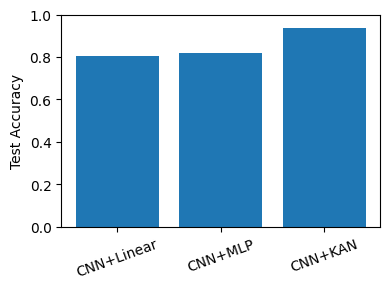

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["CNN+Linear", "CNN+MLP", "CNN+KAN"]
accs = [acc_a, acc_b, acc_c]

plt.figure(figsize=(4,3))
x = np.arange(len(labels))
plt.bar(x, accs)
plt.xticks(x, labels, rotation=20)
plt.ylabel("Test Accuracy")
plt.ylim(0,1.0)
plt.tight_layout()
plt.savefig("fig_accuracy_bar.png", dpi=200)
plt.show()


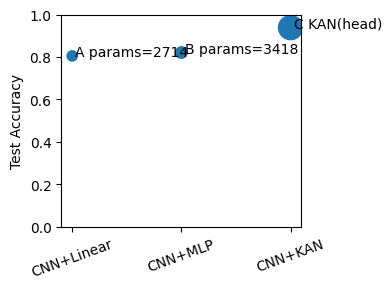

In [ ]:
import matplotlib.pyplot as plt

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

pa = count_params(model_a)
pb = count_params(model_b)
pc = None

plt.figure(figsize=(4,3))
xs = [0,1,2]
ys = [acc_a, acc_b, acc_c]
sizes = [pa/50, pb/50, 300]
labels = ["A params="+str(pa), "B params="+str(pb), "C KAN(head)"]

plt.scatter(xs, ys, s=sizes)
plt.xticks(xs, ["CNN+Linear","CNN+MLP","CNN+KAN"], rotation=20)
plt.ylabel("Test Accuracy")
plt.ylim(0,1.0)
for i, txt in enumerate(labels):
    plt.annotate(txt, (xs[i]+0.03, ys[i]))
plt.tight_layout()
plt.savefig("fig_params_vs_acc.png", dpi=200)
plt.show()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


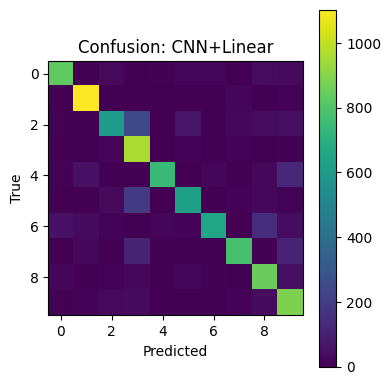

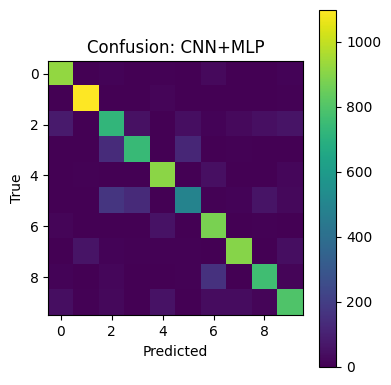

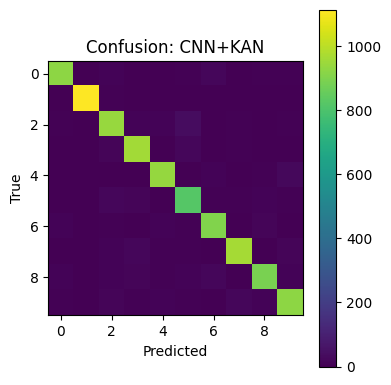

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

@torch.no_grad()
def predict_logits(model, loader, device):
    model.eval(); model.to(device)
    outs, ys = [], []
    for x,y in loader:
        x = x.to(device, non_blocking=True)
        outs.append(model(x).cpu())
        ys.append(y.cpu())
    return torch.cat(outs), torch.cat(ys)

def confmat(logits, y_true, num_classes=10):
    pred = logits.argmax(dim=1)
    cm = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    for p, t in zip(pred, y_true):
        cm[t, p] += 1
    return cm

def plot_cm(cm, title, fname):
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(fname, dpi=220)
    plt.show()

la, ya = predict_logits(model_a, test_loader, device)
lb, yb = predict_logits(model_b, test_loader, device)

backbone = model_a.backbone
@torch.no_grad()
def feats_only(backbone, loader, device):
    backbone.eval(); backbone.to(device)
    feats, ys = [], []
    for x,y in loader:
        x = x.to(device, non_blocking=True)
        feats.append(backbone(x).cpu())
        ys.append(y.cpu())
    return torch.cat(feats), torch.cat(ys)

Xte, yte = feats_only(backbone, test_loader, device)
lc = kan_model(Xte)

cma = confmat(la, ya); plot_cm(cma, "Confusion: CNN+Linear", "fig_cm_A.png")
cmb = confmat(lb, yb); plot_cm(cmb, "Confusion: CNN+MLP",   "fig_cm_B.png")
cmc = confmat(lc, yte); plot_cm(cmc, "Confusion: CNN+KAN",   "fig_cm_C.png")


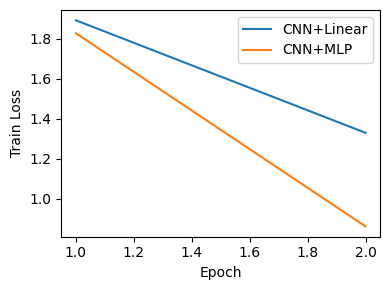

In [ ]:
import matplotlib.pyplot as plt

# If you kept running losses, replace these with your real logs.
# Otherwise, recompute tiny 1-epoch logs to illustrate curves.

def train_log(model, loader, epochs=2, lr=1e-3):
    import torch, torch.nn as nn
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()
    logs = []
    for ep in range(epochs):
        model.train()
        running = 0.0
        for x,y in loader:
            x,y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            opt.zero_grad()
            loss = crit(model(x), y)
            loss.backward()
            opt.step()
            running += loss.item()*x.size(0)
        logs.append(running/len(loader.dataset))
    return logs

ma = CNNLinear(feat_dim=16, num_classes=10)
mb = CNNMLP(feat_dim=16, num_classes=10)
logA = train_log(ma, train_loader, epochs=2)
logB = train_log(mb, train_loader, epochs=2)

plt.figure(figsize=(4,3))
plt.plot([1,2], logA, label="CNN+Linear")
plt.plot([1,2], logB, label="CNN+MLP")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.legend()
plt.tight_layout()
plt.savefig("fig_learning_curves.png", dpi=200)
plt.show()


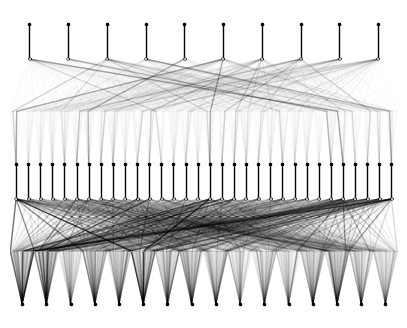

In [ ]:
_ = kan_model(Xte)
kan_model.plot()
plt.savefig("fig_kan_plot.png", dpi=220)
